# Import Dependencies

In [1]:
!pip3 install emoji -q #i used it for converting emoji to text
!pip3 install scikit-optimize -q # i used it for bayesian search in parameter optimization (modified scikitlearn library)
!pip3 install zeyrek -q #i used it for turkish lemmatization (it use rule based parser so it is so slow but works well)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.0/931.0 kB 11.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import gzip
import json
import pickle

# sparse matrix operations with scipy (in order to load save, combine features)
from scipy.sparse import save_npz, load_npz, vstack, csr_matrix, hstack

# scikit-learn preprocessing, models, and evaluation tools
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# optimization library
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

#other libraries
from imblearn.over_sampling import SMOTE
from collections import Counter
import emoji
import re
import zeyrek
import matplotlib.pyplot as plt

# load tr stopwords using nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

# google drive for ease to work in colab
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


# Influencer Category Classification



1.   Read Data
2.   Preprocess Data
3.   Prepare Model
4.   Predict Test Data
4.   Save outputs



# 1.Read Data

In [3]:
train_classification_df = pd.read_csv("/content/drive/My Drive/datasets/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

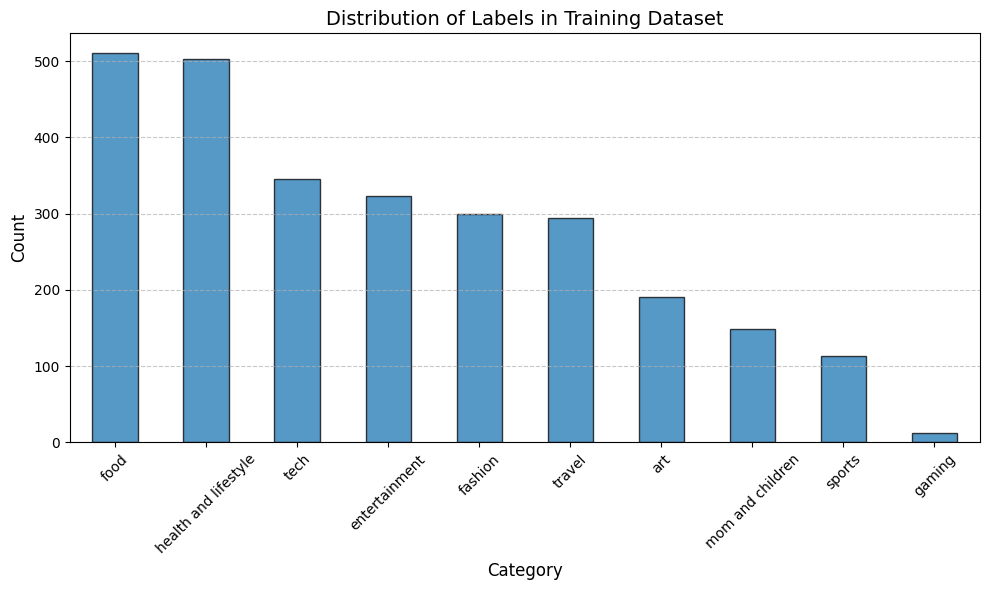

In [4]:

# calculating label counts
label_counts = train_classification_df["category"].value_counts()

# visualizing the label distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', edgecolor='black', alpha=0.75)
plt.title("Distribution of Labels in Training Dataset", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Data is imbalanced so undersampling or oversampling is needed. Gaming has very low instances, so oversampling is more sense.

In [5]:
train_data_path = "/content/drive/My Drive/datasets/training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with gzip.open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [6]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


# 2 Preprocess Data
## 2.1 Handling Missing Values

In [7]:
# check for null values in the train profile dataframe and identify the columns with missing data
null_counts = train_profile_df.isnull().sum()

# calculate the percentage of missing values for each column
null_summary = pd.DataFrame({
    "Column": train_profile_df.columns,
    "Null_Count": null_counts,
    "Null_Percentage": (null_counts / len(train_profile_df)) * 100
}).sort_values(by="Null_Count", ascending=False)

# print a summary of columns with null values
print("summary of null values in the train dataset:")
print(null_summary)

# display the first 5 rows of the train profile dataframe for inspection
print("\nfirst 5 rows of the train profile dataset:")
pd.set_option('display.max_columns', None)
display(train_profile_df.head(15))

# check the data types of all columns in the dataframe
print("\ndata types of columns in the train profile dataset:")
print(train_profile_df.dtypes)


summary of null values in the train dataset:
                                                              Column  \
restricted_by_viewer                            restricted_by_viewer   
fb_profile_biolink                                fb_profile_biolink   
ai_agent_type                                          ai_agent_type   
overall_category_name                          overall_category_name   
business_email                                        business_email   
business_phone_number                          business_phone_number   
business_category_name                        business_category_name   
post_count                                                post_count   
category_enum                                          category_enum   
category_name                                          category_name   
external_url                                            external_url   
entities                                                    entities   
biography          

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,bio_links,entities,ai_agent_type,fb_profile_biolink,restricted_by_viewer,country_block,eimu_id,external_url,fbid,has_clips,hide_like_and_view_counts,is_professional_account,is_supervision_enabled,is_guardian_of_viewer,is_supervised_by_viewer,is_supervised_user,is_embeds_disabled,is_joined_recently,business_address_json,business_contact_method,business_email,business_phone_number,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,False,6,"""[{'title': '', 'lynx_url': 'https://l.instagr...",#mediaplanning #mediabuying #sosyalmedya,None,None,None,False,110133017051179,http://www.deparmedya.com/,17841403241896337,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",CALL,None,None,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,False,15,"""[{'title': '', 'lynx_url': 'https://l.instagr...",📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,None,None,None,False,111783696881731,http://www.kafesfirin.com/,17841400227134163,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",CALL,None,None,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,vimerang,2367195567,Vimerang,Dijital İletişim Yönetimi🎬info@vimerang.comq,None,None,2321,454,True,False,False,11,"""[{'title': '', 'lynx_url': 'https://l.instagr...",Dijital İletişim Yönetimi🎬info@vimerang.comq,None,None,None,False,107818887285254,http://vimerang.com/,17841402267035899,True,True,True,False,False,False,False,False,False,"""{\""city_name\"": \""Istanbul, Turkey\"", \""city_...",CALL,None,None,Creators & Celebrities,None,VIDEO_CREATOR,False,False,https://instagram.fist19-1.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,mustafa_yalcinn38,9606564254,Mustafa Yalçın,Talas Belediye Başkanı,Politician,None,13647,29,True,False,True,2,"""[{'title': '', 'lynx_url': 'https://l.instagr...",Talas Belediye Başkanı,None,None,None,False,103944971002511,http://www.talas.bel.tr/,17841409727620820,True,False,True,False,False,False,False,False,False,"""None""",UNKNOWN,None,None,None,None,POLITICIAN,False,False,https://instagram.fist1-4.fna.fbcdn.net/v/t51....,True,False,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,zorluenergysolutions,8155780357,ZES (Zorlu Energy Solutions),Türkiye’nin 81 ilindeki en yaygın elektrikli ş...,None,None,7917,11,True,False,True,7,"""[{'title': '', 'lynx_url': 'https://l.instagr...",Türkiye’nin 81 ilindeki en yaygın elektrikli ş...,None,None,None,False,107709880628858,https://bit.ly/zeswikipedia,17841408050739472,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",UNKNOWN,None,None,None,None,ENERGY_COMPANY,False,False,https://instagram.fayt2-2.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
5,billsfooddrink,4553257121,Bill's Food & Drink,"Her katında aynı lezzet, ayrı keyif... 🍕🍸🐟\nRe...",Restaurant,None,4132,0,True,False,False,13,"""[{'title': '', 'lynx_url': 'https://l.instagr...","Her katında aynı lezzet, ayrı keyif... 🍕🍸🐟\nRe...",None,None,None,False,108921057168123,https://billsfooddrink.com/menu,17841404353659157,True,True,True,False,False,False,False,False,False,"""{\""city_name


data types of columns in the train profile dataset:
username                             object
id                                   object
full_name                            object
biography                            object
category_name                        object
post_count                           object
follower_count                       object
following_count                      object
is_business_account                  object
is_private                           object
is_verified                          object
highlight_reel_count                 object
bio_links                            object
entities                             object
ai_agent_type                        object
fb_profile_biolink                   object
restricted_by_viewer                 object
country_block                        object
eimu_id                              object
external_url                         object
fbid                                 object
has_clips              

we can remove the features which has high null percentage . for others we can fill them by 'unknown' or mode.

In [8]:
# remove columns with a high percentage of null values
columns_to_drop = [
    "business_phone_number", "restricted_by_viewer", "overall_category_name",
    "business_email", "ai_agent_type", "fb_profile_biolink", "business_category_name", "post_count", "entities"
]
train_profile_df = train_profile_df.drop(columns=columns_to_drop, errors='ignore')
test_profile_df = test_profile_df.drop(columns=columns_to_drop, errors='ignore')

# fill missing values in both training and test dataframes

# for the training dataframe
train_profile_df['category_enum'] = train_profile_df['category_enum'].fillna('bilinmiyor')
# use the most common category or a default value if the column is entirely empty
most_common_category_train = train_profile_df['category_name'].mode()[0] if not train_profile_df['category_name'].isna().all() else 'bilinmiyor'
train_profile_df['category_name'] = train_profile_df['category_name'].fillna(most_common_category_train)
train_profile_df['external_url'] = train_profile_df['external_url'].fillna('Yok')
train_profile_df['biography'] = train_profile_df['biography'].fillna('Biyografi Yok')
train_profile_df['full_name'] = train_profile_df['full_name'].fillna('Bilinmiyor')

# for the test dataframe
test_profile_df['category_enum'] = test_profile_df['category_enum'].fillna('bilinmiyor')
most_common_category_test = test_profile_df['category_name'].mode()[0] if not test_profile_df['category_name'].isna().all() else 'bilinmiyor'
test_profile_df['category_name'] = test_profile_df['category_name'].fillna(most_common_category_test)
test_profile_df['external_url'] = test_profile_df['external_url'].fillna('Yok')
test_profile_df['biography'] = test_profile_df['biography'].fillna('Biyografi Yok')
test_profile_df['full_name'] = test_profile_df['full_name'].fillna('Bilinmiyor')

# convert certain columns to numeric format where applicable
columns_to_convert = ['follower_count', 'following_count', 'highlight_reel_count']

# convert each column to float
for column in columns_to_convert:
    if column in train_profile_df.columns:
        train_profile_df[column] = pd.to_numeric(train_profile_df[column], errors='coerce')
    if column in test_profile_df.columns:
        test_profile_df[column] = pd.to_numeric(test_profile_df[column], errors='coerce')


In [9]:
#after filling the values
# check for null values in the train profile dataframe and identify columns with missing data
null_counts = train_profile_df.isnull().sum()

# calculate the percentage of missing values for each column
null_summary = pd.DataFrame({
    "Column": train_profile_df.columns,
    "Null_Count": null_counts,
    "Null_Percentage": (null_counts / len(train_profile_df)) * 100
}).sort_values(by="Null_Count", ascending=False)

# display a summary of columns with null values
print("summary of null values in the train dataset:")
print(null_summary)

# inspect the first 5 rows of the train profile dataframe
print("\nfirst 5 rows of the train profile dataset:")
pd.set_option('display.max_columns', None)
display(train_profile_df.head(15))

# check the data types of all columns in the dataframe
print("\ndata types of columns in the train profile dataset:")
print(train_profile_df.dtypes)

# print the shape of the train profile dataframe
print("\nshape of the train profile dataset:")
print(train_profile_df.shape)


summary of null values in the train dataset:
                                                              Column  \
username                                                    username   
business_contact_method                      business_contact_method   
is_guardian_of_viewer                          is_guardian_of_viewer   
is_supervised_by_viewer                      is_supervised_by_viewer   
is_supervised_user                                is_supervised_user   
is_embeds_disabled                                is_embeds_disabled   
is_joined_recently                                is_joined_recently   
business_address_json                          business_address_json   
category_enum                                          category_enum   
is_professional_account                      is_professional_account   
is_verified_by_mv4b                              is_verified_by_mv4b   
is_regulated_c18                                    is_regulated_c18   
profile_pic_url    

,username,id,full_name,biography,category_name,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,bio_links,country_block,eimu_id,external_url,fbid,has_clips,hide_like_and_view_counts,is_professional_account,is_supervision_enabled,is_guardian_of_viewer,is_supervised_by_viewer,is_supervised_user,is_embeds_disabled,is_joined_recently,business_address_json,business_contact_method,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,1167,192,True,False,False,6,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,110133017051179,http://www.deparmedya.com/,17841403241896337,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",CALL,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,11997,17,True,False,False,15,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,111783696881731,http://www.kafesfirin.com/,17841400227134163,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",CALL,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,vimerang,2367195567,Vimerang,Dijital İletişim Yönetimi🎬info@vimerang.comq,Product/service,2321,454,True,False,False,11,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,107818887285254,http://vimerang.com/,17841402267035899,True,True,True,False,False,False,False,False,False,"""{\""city_name\"": \""Istanbul, Turkey\"", \""city_...",CALL,VIDEO_CREATOR,False,False,https://instagram.fist19-1.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,mustafa_yalcinn38,9606564254,Mustafa Yalçın,Talas Belediye Başkanı,Politician,13647,29,True,False,True,2,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,103944971002511,http://www.talas.bel.tr/,17841409727620820,True,False,True,False,False,False,False,False,False,"""None""",UNKNOWN,POLITICIAN,False,False,https://instagram.fist1-4.fna.fbcdn.net/v/t51....,True,False,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,zorluenergysolutions,8155780357,ZES (Zorlu Energy Solutions),Türkiye’nin 81 ilindeki en yaygın elektrikli ş...,Product/service,7917,11,True,False,True,7,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,107709880628858,https://bit.ly/zeswikipedia,17841408050739472,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",UNKNOWN,ENERGY_COMPANY,False,False,https://instagram.fayt2-2.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
5,billsfooddrink,4553257121,Bill's Food & Drink,"Her katında aynı lezzet, ayrı keyif... 🍕🍸🐟\nRe...",Restaurant,4132,0,True,False,False,13,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,108921057168123,https://billsfooddrink.com/menu,17841404353659157,True,True,True,False,False,False,False,False,False,"""{\""city_name\"": \""\\u0130zmir, Turkey\"", \""ci...",CALL,RESTAURANT,False,False,https://z-p42-instagram.fesb10-2.fna.fbcdn.net...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
6,cpmyazilim,2330240085,CPM Yazılım,Yerli yerinde çözümler,Software Company,1392,8,True,False,False,6,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,120405096020698,Yok,17841402162571280,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": \""Istanbul, Turkey\"", \""city_...",CALL,SOFTWARE_COMPANY,False,False,https://instagram.fayt2-2.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGB


data types of columns in the train profile dataset:
username                             object
id                                   object
full_name                            object
biography                            object
category_name                        object
follower_count                        int64
following_count                       int64
is_business_account                  object
is_private                           object
is_verified                          object
highlight_reel_count                  int64
bio_links                            object
country_block                        object
eimu_id                              object
external_url                         object
fbid                                 object
has_clips                            object
hide_like_and_view_counts            object
is_professional_account              object
is_supervision_enabled               object
is_guardian_of_viewer                object
is_supervised_by_viewer

everything looks fine

In [ ]:
print(test_profile_df.shape, train_profile_df.shape)

(2674, 35) (2741, 35)


In [ ]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,bio_links,country_block,eimu_id,external_url,fbid,has_clips,hide_like_and_view_counts,is_professional_account,is_supervision_enabled,is_guardian_of_viewer,is_supervised_by_viewer,is_supervised_user,is_embeds_disabled,is_joined_recently,business_address_json,business_contact_method,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,1265,665,True,False,False,0,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,109046377161056,http://yinemipazartesi.wordpress.com/,17841408443109307,False,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",UNKNOWN,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,28025,4,True,False,False,10,"""[{'title': '', 'lynx_url': 'https://l.instagr...",False,112204746839186,https://bit.ly/45XDUDr,17841407073803330,True,False,True,False,False,False,False,False,False,"""{\""city_name\"": null, \""city_id\"": null, \""la...",CALL,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


## 2.2 Preprocess and Create Post Features

In [10]:
import logging
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
# zeyrek logs all parsing steps, so suppress them to keep the output clean
logging.getLogger("zeyrek.rulebasedanalyzer").setLevel(logging.ERROR)

# initialize the zeyrek analyzer
analyzer = zeyrek.MorphAnalyzer()

# download required nltk data for tokenization
nltk.download('punkt')

def preprocess_text(text: str):
    """
    preprocesses the given turkish text, including cleaning and optional lemmatization.
    """
    # convert text to lowercase (casefold handles turkish-specific characters correctly)
    text = text.casefold()

    # remove urls from the text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # convert emojis into their textual descriptions
    text = emoji.demojize(text)

    # remove special characters and punctuation
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # remove all numbers
    text = re.sub(r'\d+', '', text)

    # replace multiple spaces with a single space and trim leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()

    '''
    i used lemmatization and submitted my results based on that approach. however,
    i saved the lemmatized data and developed my model from it.
    while uploading the code, lemmatization is commented out because it is computationally expensive.
    so if onur hoca wants to run the code, he doesn’t have to wait 6 hours :)

    # split text into words and lemmatize each word
    words = text.split()
    lemmatized_words = []
    for word in words:
        analysis = analyzer.lemmatize(word)
        # select the first lemma from the analysis, or keep the word if analysis fails
        lemma = analysis[0][1][0] if analysis else word
        lemmatized_words.append(lemma)

    # join the lemmatized words back into a single string
    text = ' '.join(lemmatized_words)
    '''

    return text


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
corpus = []

# to keep the label order
train_usernames = []

# total number of users for progress tracking
total_users = len(username2posts_train)
processed_users = 0

print(f"Total Train User: {total_users}")

for username, posts in username2posts_train.items():
    train_usernames.append(username)

    # aggregating the posts per user
    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_captions.append(post_caption)

    # joining the posts of each user with a \n
    user_post_captions = "\n".join(cleaned_captions)
    corpus.append(user_post_captions)

    # increment processed train user count and display progress (in order to keeep track)
    processed_users += 1
    if processed_users %500 == 0 or processed_users == total_users:
        print(f"Preprocessed User: {processed_users}/{total_users}")

vectorizer = TfidfVectorizer(
    max_features=5000,  # Maksimum özellik sayısı
    stop_words=turkish_stopwords,
    ngram_range=(1,2)
)

# fit the vectorizer
vectorizer.fit(corpus)

# transform the data into vectors
x_post_train = vectorizer.transform(corpus)

y_train = [username2_category.get(uname, "NA") for uname in train_usernames]

test_usernames = []
test_corpus = []
total_test_users = len(username2posts_test)
processed_test_users = 0

print(f"Total test user: {total_test_users}")

for username, posts in username2posts_test.items():
    test_usernames.append(username)
    # aggregating the posts per user

    cleaned_captions = []
    for post in posts:
        post_caption = post.get("caption", "")
        if post_caption is None:
            continue

        post_caption = preprocess_text(post_caption)

        if post_caption != "":
            cleaned_captions.append(post_caption)

    user_post_captions = "\n".join(cleaned_captions)
    test_corpus.append(user_post_captions)

    # increment processed test user count and display progress (in order to keeep track)
    processed_test_users += 1
    if processed_test_users % 500 == 0 or processed_test_users == total_test_users:
        print(f"Preprocessed User: {processed_test_users}/{total_test_users}")

# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)


Total Train User: 2741
Preprocessed User: 500/2741
Preprocessed User: 1000/2741
Preprocessed User: 1500/2741
Preprocessed User: 2000/2741
Preprocessed User: 2500/2741
Preprocessed User: 2741/2741
Total test user: 2674
Preprocessed User: 500/2674
Preprocessed User: 1000/2674
Preprocessed User: 1500/2674
Preprocessed User: 2000/2674
Preprocessed User: 2500/2674
Preprocessed User: 2674/2674


## 2.3 Preprocess and Create Biography Text Features

In [ ]:
# collect biography data
train_biographies = train_profile_df['biography'].fillna('').tolist()
test_biographies = test_profile_df['biography'].fillna('').tolist()

# preprocess the biography texts
train_biographies_cleaned = [preprocess_text(bio) for bio in train_biographies]
test_biographies_cleaned = [preprocess_text(bio) for bio in test_biographies]

# create a separate tf-idf vectorizer for biographies
vectorizer_bio = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000, ngram_range=(1, 2))
vectorizer_bio.fit(train_biographies_cleaned)

# vectorize the biography data
x_bio_train = vectorizer_bio.transform(train_biographies_cleaned)
x_bio_train = x_bio_train.multiply(3)  # apply scaling to emphasize the importance of biography features
x_bio_test = vectorizer_bio.transform(test_biographies_cleaned)
x_bio_test = x_bio_test.multiply(3)  # apply the same scaling for consistency

# combine biography tf-idf and post tf-idf
x_combined_train = hstack([x_bio_train, x_post_train])
x_combined_test = hstack([x_bio_test, x_post_test])



## 2.4 Preprocess and Create Numeric Features

In [ ]:
# identify numerical and categorical columns
numerical_columns = ['follower_count', 'following_count', 'highlight_reel_count']
categorical_columns = ['category_name', 'is_business_account', 'is_private', 'is_verified']

# transform numerical and categorical features using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),  # scale numerical columns
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)  # one-hot encode categorical columns
    ],
    remainder='drop'  # drop other columns
)

# transform numerical and categorical features
X_train_other = preprocessor.fit_transform(train_profile_df)
X_test_other = preprocessor.transform(test_profile_df)


In [ ]:
#combine them with our combined tf-idf
X_train_final = hstack([X_train_other, x_combined_train])
X_test_final = hstack([X_test_other, x_combined_test])

In [ ]:
# feature stats to examine and save names for later use

# retrieve numerical and categorical feature names
numerical_feature_names = numerical_columns
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist()
numerical_and_categorical_feature_names = numerical_feature_names + categorical_feature_names

# retrieve tf-idf feature names
post_tfidf_feature_names = vectorizer.get_feature_names_out()
bio_tfidf_feature_names = vectorizer_bio.get_feature_names_out()
tfidf_feature_names = list(post_tfidf_feature_names) + list(bio_tfidf_feature_names)

# combine all feature names
feature_names = numerical_and_categorical_feature_names + tfidf_feature_names

print(f"Total Number of Features: {len(feature_names)}")


# 3. Prepare the Model
## 3.1 Oversampling with SMOTE for Class Imblance

In [ ]:
# during the development phase, lemmatization turned out to be very time-consuming.
# to avoid recomputing the same preprocessed data repeatedly, the processed data is saved
# and reloaded when needed. this way, i save time and focus on model training and evaluation.

# save training and test data
drive_path = "/content/drive/My Drive/datasets/"

# save additional information needed for model usage and evaluation
save_npz(drive_path + "X_train_final.npz", X_train_final)
save_npz(drive_path + "X_test_final.npz", X_test_final)

# Model kullanımında ve değerlendirmesinde gerekli ek bilgileri hazırlama
data_info = {
    "y_train": y_train,             # Eğitim etiketleri
    "label_encoder": label_encoder, # Tahminlerin çözümlenmesi için label encoder
    "feature_names": feature_names  # Modelde kullanılan özellik isimleri
}

# store the additional information in a pickle file
with open(drive_path + "data_info.pkl", "wb") as f:
    pickle.dump(data_info, f)

print("Training and test data, along with additional information, have been successfully saved to your Google Drive.")

In [ ]:
# define the path to load the saved data
drive_path = "/content/drive/My Drive/datasets/"

# load training and test data in sparse format
X_train_final = load_npz(drive_path + "X_train_final.npz")  # training data
X_test_final = load_npz(drive_path + "X_test_final.npz")    # test data

# load additional information stored in pickle format
with open(drive_path + "data_info.pkl", "rb") as f:
    data_info = pickle.load(f)

# extract variables from the additional information
y_train = data_info["y_train"]                # training labels
label_encoder = data_info["label_encoder"]    # label encoder for decoding predictions
feature_names = data_info["feature_names"]    # feature names used in the model

print("training and test data, along with additional information, have been successfully loaded from your google drive.")


training and test data, along with additional information, have been successfully loaded from your google drive.


In [ ]:
# 3. label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)  # encode the target variable

# check the original class distribution
print("original class distribution:")
print(Counter(y_encoded))  # print the class distribution of the training data

# smote strategy for balancing classes
# target: a more balanced distribution with specific samples per class
smote_strategy = {
    0: 1200,   # art
    1: 1800,   # entertainment
    2: 1200,   # fashion
    3: 1000,   # food
    4: 700,    # gaming
    5: 1800,   # health and lifestyle
    6: 700,    # mom and children
    7: 700,    # sports
    8: 1200,   # tech
    9: 1200    # travel
}

# apply smote with the defined strategy
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_final, y_encoded)

# check the class distribution after SMOTE
print("\nclass distribution after smote:")
print(Counter(y_resampled))

original class distribution:
Counter({3: 511, 5: 502, 8: 346, 1: 323, 2: 299, 9: 294, 0: 191, 6: 149, 7: 113, 4: 13})

class distribution after smote:
Counter({5: 1800, 1: 1800, 8: 1200, 9: 1200, 2: 1200, 0: 1200, 3: 1000, 7: 700, 6: 700, 4: 700})


## 3.2 Train the model with Stacking Classifier (Base: RandomForest, Meta: Logistic Regression )

In [ ]:
# stratified k-fold validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
classification_reports = []

# define the base model
base_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# define the meta model
meta_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# define the stacking classifier (combining base and meta models)
stacking_model = StackingClassifier(
    estimators=[('base', base_model)],  # base model
    final_estimator=meta_model,         # meta model
    passthrough=True,                   # pass base model outputs to the meta model
    cv=5                                # cross-validation for training the meta model
)

print("\ntraining the meta-classifier:\n")
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_resampled, y_resampled)):
    print(f"\nfold {fold+1}")

    # train-validation split for the current fold
    X_train_fold, X_val_fold = X_resampled[train_idx], X_resampled[val_idx]
    y_train_fold, y_val_fold = y_resampled[train_idx], y_resampled[val_idx]

    # train the stacking model on the current fold
    stacking_model.fit(X_train_fold, y_train_fold)

    # predict on the validation set
    y_val_pred = stacking_model.predict(X_val_fold)
    fold_acc = accuracy_score(y_val_fold, y_val_pred)
    fold_accuracies.append(fold_acc)

    # generate classification report for the current fold
    report = classification_report(y_val_fold, y_val_pred, target_names=label_encoder.classes_, zero_division=0)
    classification_reports.append(report)
    print(f"fold {fold+1} classification report:")
    print(report)

# calculate and display the average cross-validation accuracy
average_accuracy = np.mean(fold_accuracies)
print(f"\naverage cross-validation accuracy: {average_accuracy:.4f}")


training the meta-classifier:


fold 1
fold 1 classification report:
                      precision    recall  f1-score   support

                 art       0.98      0.96      0.97       240
       entertainment       0.99      0.99      0.99       360
             fashion       0.93      0.99      0.96       240
                food       0.96      0.96      0.96       200
              gaming       1.00      1.00      1.00       140
health and lifestyle       0.98      0.94      0.96       360
    mom and children       0.97      0.94      0.95       140
              sports       0.99      0.99      0.99       140
                tech       0.94      0.98      0.96       240
              travel       0.99      0.98      0.98       240

            accuracy                           0.97      2300
           macro avg       0.97      0.97      0.97      2300
        weighted avg       0.97      0.97      0.97      2300


fold 2
fold 2 classification report:
                     

## 3.3 Bayesian Search Hyperparameter Tunining (Computationally Expensive)

In [ ]:
# hyperparameter search space
param_space = {
    'base__n_estimators': Integer(50, 200),  # number of trees for Random Forest
    'base__max_depth': Categorical([None, 10, 20]),  # maximum depth for Random Forest
    'final_estimator__C': Real(0.01, 10, prior='log-uniform'),  # C parameter for Logistic Regression
    'final_estimator__solver': Categorical(['lbfgs', 'liblinear'])  # solver for Logistic Regression
}

# bayesian optimization for hyperparameter tuning
bayes_search = BayesSearchCV(
    estimator=stacking_model,  # using the previously defined stacking_model
    search_spaces=param_space,
    n_iter=20,  # number of iterations
    scoring='accuracy',  # evaluation metric
    cv=3,  # number of cross-validation folds
    n_jobs=-1,  # utilize all available processors
    random_state=42
)

# train the model and find the best hyperparameters
bayes_search.fit(X_resampled, y_resampled)

# best hyperparameters and accuracy
print("best hyperparameters:", bayes_search.best_params_)
print("best accuracy:", bayes_search.best_score_)

# use the best model for predictions
best_model = bayes_search.best_estimator_


best hyperparameters: OrderedDict([('base__max_depth', 10), ('base__n_estimators', 200), ('final_estimator__C', 5.110892018557016), ('final_estimator__solver', 'liblinear')])
best accuracy: 0.9749605588165954


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

# take the best hyperparameters from BayesSearchCV results
best_params = {
    'base__max_depth': 10,
    'base__n_estimators': 200,
    'final_estimator__C': 5.110892018557016,
    'final_estimator__solver': 'liblinear'
}


# define the best base and meta models based on optimized parameters
best_base_model = RandomForestClassifier(
    n_estimators=best_params['base__n_estimators'],
    max_depth=best_params['base__max_depth'],
    random_state=42
)
best_meta_model = LogisticRegression(
    C=best_params['final_estimator__C'],
    solver=best_params['final_estimator__solver'],
    max_iter=1000,
    random_state=42
)

# reconstruct the stacking classifier with the best parameters
best_stacking_model = StackingClassifier(
    estimators=[('base', best_base_model)],
    final_estimator=best_meta_model,
    passthrough=True
)

# stratified k-fold validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
classification_reports = []
all_y_true = []
all_y_pred = []
all_y_proba = []

print("\ntraining with the best parameters:\n")
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_resampled, y_resampled)):
    print(f"\nfold {fold+1}")

    # train-validation split for the current fold
    X_train_fold, X_val_fold = X_resampled[train_idx], X_resampled[val_idx]
    y_train_fold, y_val_fold = y_resampled[train_idx], y_resampled[val_idx]

    # train the model on the current fold
    best_stacking_model.fit(X_train_fold, y_train_fold)

    # predict on the validation set
    y_val_pred = best_stacking_model.predict(X_val_fold)
    y_val_proba = best_stacking_model.predict_proba(X_val_fold)

    fold_acc = accuracy_score(y_val_fold, y_val_pred)
    fold_accuracies.append(fold_acc)

    # append predictions, probabilities, and true labels
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_val_pred)
    all_y_proba.extend(y_val_proba)

    # generate classification report for the current fold
    report = classification_report(y_val_fold, y_val_pred, target_names=label_encoder.classes_, zero_division=0)
    classification_reports.append(report)
    print(f"fold {fold+1} classification report:")
    print(report)





training with the best parameters:


fold 1
fold 1 classification report:
                      precision    recall  f1-score   support

                 art       0.99      0.98      0.98       240
       entertainment       0.98      0.99      0.98       360
             fashion       0.94      0.99      0.97       240
                food       0.95      0.94      0.95       200
              gaming       1.00      1.00      1.00       140
health and lifestyle       0.99      0.95      0.97       360
    mom and children       0.97      0.95      0.96       140
              sports       0.98      1.00      0.99       140
                tech       0.97      0.97      0.97       240
              travel       0.99      0.98      0.99       240

            accuracy                           0.98      2300
           macro avg       0.98      0.98      0.98      2300
        weighted avg       0.98      0.98      0.98      2300


fold 2
fold 2 classification report:
                

## 3.4 Plot the Model's Performance (Val Set)


average cross-validation accuracy: 0.9729


<Figure size 1200x1000 with 0 Axes>

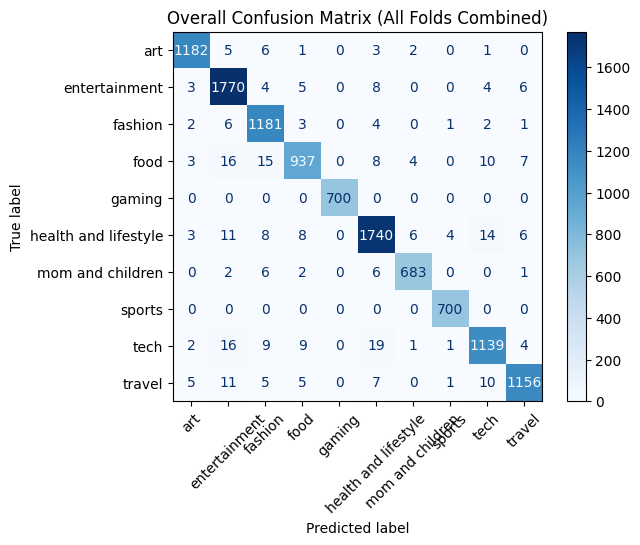

In [ ]:
# calculate and display the average cross-validation accuracy
average_accuracy = np.mean(fold_accuracies)
print(f"\naverage cross-validation accuracy: {average_accuracy:.4f}")

# generate the confusion matrix for the entire dataset
cm = confusion_matrix(all_y_true, all_y_pred, labels=np.unique(all_y_true))

# plot the overall confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
plt.figure(figsize=(12, 10))
disp.plot(cmap='Blues', xticks_rotation=45, values_format='d')
plt.title('Overall Confusion Matrix (All Folds Combined)')
plt.show()


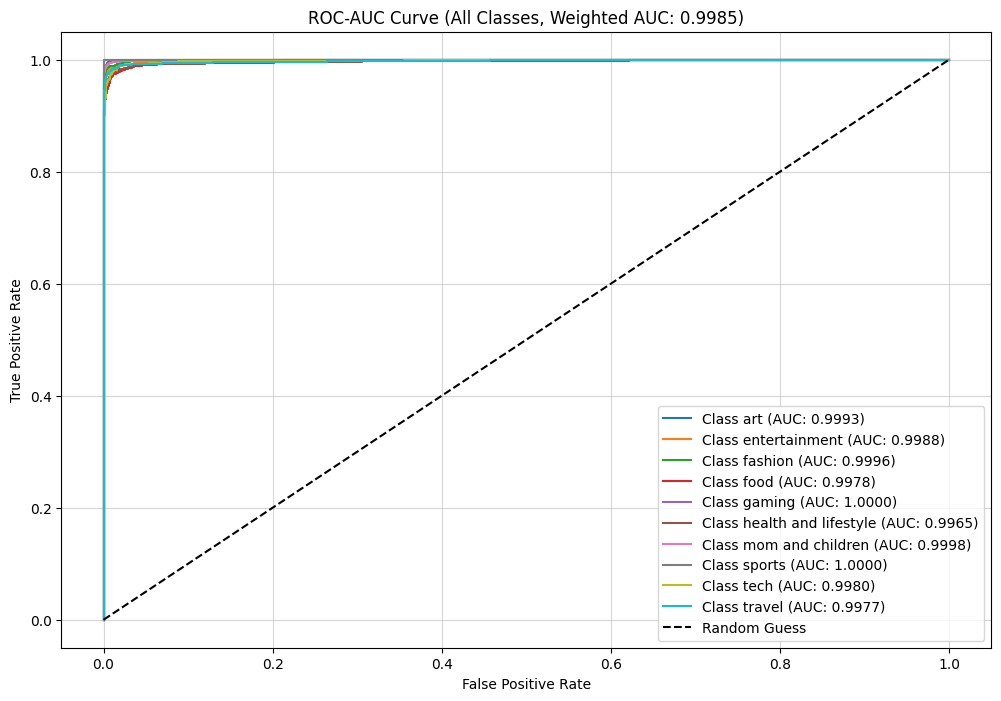

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# compute weighted ROC-AUC score (one-vs-rest for multi-class)
roc_auc_weighted = roc_auc_score(all_y_true, all_y_proba, multi_class="ovr", average="weighted")

# plot the ROC curve for each class
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(label_encoder.classes_):
    # compute ROC curve for each class
    fpr, tpr, _ = roc_curve(np.array(all_y_true) == i, np.array(all_y_proba)[:, i])
    auc_score = roc_auc_score(np.array(all_y_true) == i, np.array(all_y_proba)[:, i])

    # plot the ROC curve for the current class
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC: {auc_score:.4f})")  # 4 decimal points

# plot the diagonal line for random guess
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

# add title and labels
plt.title(f"ROC-AUC Curve (All Classes, Weighted AUC: {roc_auc_weighted:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.5)

# display the plot
plt.show()


# 4. Predict the Test Data

In [ ]:
# loading test data
test_data_path = "/content/drive/My Drive/datasets/test-classification-round3.dat"
print("first 5 rows of the test data:")
!head -n 5 "$test_data_path"

test_unames = []
# reading test usernames
with open(test_data_path, "rt") as fh:
    for line in fh:
        test_unames.append(line.strip())

print("First 5 test usernames:", test_unames[:5])

# creating the test dataset
x_test = []
missing_unames = []

for uname in test_unames:
    try:
        # find username in test_usernames and add its corresponding data
        index = test_usernames.index(uname)
        x_test.append(X_test_final[index].toarray()[0])  # adding features based on posts
    except Exception:
        try:
            # if not found in test_usernames, search in train_usernames
            index = train_usernames.index(uname)
            x_test.append(X_train_final[index].toarray()[0])  # adding features from training data
        except Exception:
            # if username is missing in both, add to the missing list
            missing_unames.append(uname)
#in order to delete if we have (roun1 : screenname)
print(f"Missing usernames: {missing_unames}")

# converting test data into a DataFrame
df_test = pd.DataFrame(np.array(x_test), columns=feature_names)
print(f"Test dataset shape: {df_test.shape}")


first 5 rows of the test data:
livapastanesi
barisgross
tusasshop
etolyadigital
tugrulonur
First 5 test usernames: ['livapastanesi', 'barisgross', 'tusasshop', 'etolyadigital', 'tugrulonur']
Missing usernames: []
Test dataset shape: (1000, 10342)


In [ ]:
# retrain the model using the entire training dataset
best_stacking_model.fit(X_resampled, y_resampled)

# make predictions on the test set
y_test_pred = best_stacking_model.predict(df_test)

#if hyperparameter tuning was no runned bcz of its time complexity use below code
#y_test_pred = stacking_model.predict.(df_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# 5. Save Outputs

In [ ]:
# convert predictions back to category names
decoded_predictions = label_encoder.inverse_transform(y_test_pred)

# save predictions in JSON format
output = {uname: decoded_predictions[i] for i, uname in enumerate(test_unames)}

output_file = "/content/drive/My Drive/datasets/prediction-classification-round3.json"
with open(output_file, "w") as of:
    json.dump(output, of, indent=4)

print(f"Predictions have been saved in the file: '{output_file}'")


Predictions have been saved in the file: '/content/drive/My Drive/datasets/prediction-classification-round3.json' with category names.
Predictions have been saved in the file: '/content/drive/My Drive/datasets/prediction-classification-round3.json' with category names.


# Like Count Prediction




1. Dataset Creation
2. Feature Extraction
3. Feature Engineering
4. Model Training
5. Save the Output

## 1. Dataset Creation

In [12]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
import json
import numpy as np

# load the test dataset and extract post IDs
test_path = "/content/drive/My Drive/datasets/test-regression-round3.jsonl"

test_posts = []
test_post_ids = set()

with open(test_path, "rt") as fh:
    for line in fh:
        sample = json.loads(line)
        test_posts.append(sample)  # added the test posts to a list
        test_post_ids.add(sample["id"])  # stored the post IDs for later checks

# now, for the remaining posts, create train and validation sets
train_val_posts = []

for username, posts in username2posts_train.items():
    for post in posts:
        if post["id"] not in test_post_ids:  # only include posts not in the test set
            # make sure the username exists in the training profiles
            if username not in train_profile_df["username"].values:
                raise ValueError(f"username '{username}' not found in train_profile_df!")

            # match the user profile and add relevant attributes to the post
            user_row = train_profile_df[train_profile_df["username"] == username].iloc[0]
            post["username"] = username
            post["follower_count"] = user_row["follower_count"]
            post["following_count"] = user_row["following_count"]
            post["is_business_account"] = user_row["is_business_account"]
            post["is_private"] = user_row["is_private"]
            post["is_verified"] = user_row["is_verified"]
            post["highlight_reel_count"] = user_row["highlight_reel_count"]
            post["is_joined_recently"] = user_row["is_joined_recently"]
            train_val_posts.append(post)

for username, posts in username2posts_test.items():
    for post in posts:
        if post["id"] not in test_post_ids:  # only include posts not in the test set
            # make sure the username exists in the test profiles
            if username not in test_profile_df["username"].values:
                raise ValueError(f"username '{username}' not found in test_profile_df!")

            # match the user profile and add relevant attributes to the post
            user_row = test_profile_df[test_profile_df["username"] == username].iloc[0]
            post["username"] = username
            post["follower_count"] = user_row["follower_count"]
            post["following_count"] = user_row["following_count"]
            post["is_business_account"] = user_row["is_business_account"]
            post["is_private"] = user_row["is_private"]
            post["is_verified"] = user_row["is_verified"]
            post["highlight_reel_count"] = user_row["highlight_reel_count"]
            post["is_joined_recently"] = user_row["is_joined_recently"]
            train_val_posts.append(post)


In [13]:
# matching username information in test posts and adding features
for post in test_posts:
    username = post.get("username", None)  # get username from the post, if available
    if username:
        # search for the username in `train_profile_df` and `test_profile_df`
        if username in train_profile_df["username"].values:
            user_row = train_profile_df[train_profile_df["username"] == username].iloc[0]
        elif username in test_profile_df["username"].values:
            user_row = test_profile_df[test_profile_df["username"] == username].iloc[0]
        else:
            raise ValueError(f"Username '{username}' not found in train_profile_df or test_profile_df!")

        # adding features from the user profile
        post["follower_count"] = user_row["follower_count"]  # number of followers
        post["following_count"] = user_row["following_count"]  # number of followings
        post["is_business_account"] = user_row["is_business_account"]  # is it a business account
        post["is_private"] = user_row["is_private"]  # is the account private
        post["is_verified"] = user_row["is_verified"]  # is the account verified
        post["highlight_reel_count"] = user_row["highlight_reel_count"]  # number of highlights
        post["is_joined_recently"] = user_row["is_joined_recently"]  # is it a recently joined account

        # find the user's posts from username2posts_train or username2posts_test
        if username in username2posts_train:
            user_posts = username2posts_train[username]
        elif username in username2posts_test:
            user_posts = username2posts_test[username]
        else:
            user_posts = []

        # calculate the user's average like_count and comments_count values
        avg_like_count = (
            np.mean([0 if p.get("like_count") is None else p.get("like_count", 0) for p in user_posts])
            if user_posts else 0
        )
        avg_comment_count = (
            np.mean([0 if p.get("comments_count") is None else p.get("comments_count", 0) for p in user_posts])
            if user_posts else 0
        )

        # add the calculated averages and total post count
        post["avg_like_count"] = avg_like_count
        post["avg_comment_count"] = avg_comment_count

# train-validation split
train_posts, val_posts = train_test_split(train_val_posts, test_size=0.15, random_state=42)

# check the split
print(f"Number of train posts: {len(train_posts)}")
print(f"Number of validation posts: {len(val_posts)}")
print(f"Number of test posts: {len(test_posts)}")


Train post sayısı: 159206
Validation post sayısı: 28096
Test post sayısı: 3000


In [14]:
# creating dictionaries for train, validation, and test sets
posts_train = defaultdict(list)  # dictionary to hold train posts grouped by username
posts_val = defaultdict(list)  # dictionary to hold validation posts grouped by username
posts_test = defaultdict(list)  # dictionary to hold test posts grouped by username

#group the posts by user for feature extracion late
# populate the train set
for post in train_posts:
    posts_train[post["username"]].append(post)  # group train posts by username

# populate the validation set
for post in val_posts:
    posts_val[post["username"]].append(post)  # group validation posts by username

# populate the test set (posts coming from the file)
for post in test_posts:
    posts_test[post["username"]].append(post)  # group test posts by username


## 2.Feature Extraction

In [15]:
import numpy as np
import re
from collections import defaultdict

# function to count the number of hashtags in a text
def count_hashtags(text):
    if text is not None:  # check if the text is not None
        return text.count('#')  # count occurrences of '#'
    else:
        return 0  # return 0 if text is None

# function to count the number of emojis in a text
def count_emojis(text):
    if not isinstance(text, str):  # check if the text is not a string
        text = ""  # set text to an empty string
    emojis = re.findall(r'[^\w\s,]', text)  # find emojis using a regex that captures non-word, non-space characters
    return len(emojis)  # return the number of emojis


In [16]:
def extract_group_features(group_posts, user_posts_data):
    features = []  # to store features for each post
    targets = []  # to store target like counts
    ids = []  # to store post IDs

    for post in group_posts:
        # get caption and handle missing values
        caption = post.get("caption", "")
        if caption is None:
            caption = ""

        # get user's posts based on username
        username = post.get("username", "")
        user_posts = user_posts_data.get(username, [])

        # calculate average likes and comments for the user
        avg_like_count = (
            np.mean([0 if p.get("like_count") is None else p.get("like_count", 0) for p in user_posts])
            if user_posts else 0
        )
        avg_comment_count = (
            np.mean([0 if p.get("comments_count") is None else p.get("comments_count", 0) for p in user_posts])
            if user_posts else 0
        )

        # grab additional user details
        follower_count = post.get("follower_count", 0)
        following_count = post.get("following_count", 0)
        is_business_account = int(post.get("is_business_account", False))
        is_private = int(post.get("is_private", False))
        is_verified = int(post.get("is_verified", False))
        highlight_reel_count = post.get("highlight_reel_count", 0)
        is_joined_recently = int(post.get("is_joined_recently", False))
        id = post.get("id")

        # build feature list for the post
        features.append([
            len(caption.split()),  # word count in caption
            count_emojis(caption),  # emoji count in caption
            follower_count,
            following_count,
            is_business_account,
            is_private,
            is_verified,
            highlight_reel_count,
            is_joined_recently,
            post.get("comments_count", 0),
            caption.count("#"),  # hashtag count
            avg_like_count,
            avg_comment_count,
        ])
        ids.append(id)

        # handle and log-transform like count
        like_count = post.get("like_count", 0)
        if like_count is None:
            like_count = 0
        targets.append(like_count)

    return np.array(features), np.log1p(np.array(targets)), np.array(ids)


In [17]:
# extracting features and IDs for the train and validation sets
X_train, y_train, train_ids = extract_group_features(train_posts, posts_train)  # train set features and IDs
X_val, y_val, val_ids = extract_group_features(val_posts, posts_val)  # validation set features and IDs


In [18]:
def extract_group_features_test(group_posts, user_posts_data):
    features = []  # list to store features for test posts
    ids = []  # list to store post IDs

    for post in group_posts:
        # check and handle the caption
        caption = post.get("caption", "")
        if caption is None:
            caption = ""

        # get user's posts based on username
        username = post.get("username", "")
        user_posts = user_posts_data.get(username, [])

        # additional user information from the post
        avg_like_count = post.get("avg_like_count", 0)
        avg_comment_count = post.get("avg_comment_count", 0)
        follower_count = post.get("follower_count", 0)
        following_count = post.get("following_count", 0)
        is_business_account = int(post.get("is_business_account", False))
        is_private = int(post.get("is_private", False))
        is_verified = int(post.get("is_verified", False))
        highlight_reel_count = post.get("highlight_reel_count", 0)
        is_joined_recently = int(post.get("is_joined_recently", False))
        id = post.get("id")
        ids.append(id)

        # build feature list for the current post
        features.append([
            len(caption.split()),  # word count in caption
            count_emojis(caption),  # emoji count in caption
            follower_count,
            following_count,
            is_business_account,
            is_private,
            is_verified,
            highlight_reel_count,
            is_joined_recently,
            post.get("comments_count", 0),  # number of comments
            caption.count("#"),  # hashtag count
            avg_like_count,
            avg_comment_count,
        ])

    # return features and IDs as NumPy arrays
    return np.array(features), np.array(ids)


In [19]:
X_test , test_ids = extract_group_features_test(test_posts, posts_test)

In [65]:
import pandas as pd

# train set features and targets
X_train_df = pd.DataFrame(X_train, columns=[
    "caption_word_count",  # number of words in the caption
    "emoji_count",  # number of emojis in the caption
    "follower_count",  # number of followers
    "following_count",  # number of followings
    "is_business_account",  # is it a business account
    "is_private",  # is the profile private
    "is_verified",  # is the profile verified
    "highlight_reel_count",  # number of highlight reels
    "is_joined_recently",  # is the account recently created
    "comments_count",  # number of comments
    "hashtag_count",  # number of hashtags
    "avg_like_count",  # user's average like count
    "avg_comment_count",  # user's average comment count
])

# validation set features and targets
X_val_df = pd.DataFrame(X_val, columns=X_train_df.columns[:X_val.shape[1]])
y_val_df = pd.DataFrame(np.expm1(y_val), columns=["like_count"])  # inverse log transformation for targets (for visualisation and result checking (not for model training))

# train set targets
y_train_df = pd.DataFrame(np.expm1(y_train), columns=["like_count"])  # inverse log transformation for targets (for visualisation and result checking (not for model training)

# display first 10 rows of train set
print("Train Dataset")
display(X_train_df.join(y_train_df).head(10))

# display first 10 rows of validation set
print("\nValidation Dataset")
display(X_val_df.join(y_val_df).head(10))


Train Dataset


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,like_count
0,74.0,15.0,11802.0,130.0,1.0,0.0,0.0,23.0,0.0,0.0,2.0,83.200000,0.133333,79.0
1,3.0,1.0,287438.0,509.0,0.0,0.0,1.0,41.0,0.0,29.0,0.0,11577.454545,38.545455,7837.0
2,26.0,27.0,52392.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,22.0,90.620690,0.931034,233.0
3,12.0,8.0,60527.0,14.0,1.0,0.0,0.0,11.0,0.0,0.0,3.0,51.714286,0.428571,43.0
4,38.0,7.0,1635.0,90.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,40.161290,1.000000,58.0
5,90.0,12.0,1641.0,134.0,1.0,0.0,0.0,19.0,0.0,0.0,6.0,20.888889,0.555556,14.0
6,4.0,5.0,160151.0,1269.0,0.0,0.0,1.0,3.0,0.0,10.0,0.0,1160.242424,21.424242,1509.0
7,1.0,1.0,37550.0,6.0,1.0,0.0,1.0,16.0,0.0,0.0,1.0,39.290323,0.483871,32.0
8,13.0,14.0,42146.0,2.0,1.0,0.0,0.0,14.0,0.0,0.0,11.0,13.281250,0.531250,14.0
9,33.0,9.0,6074.0,419.0,0.0,0.0,1.0,8.0,0.0,0.0,3.0,9.629630,0.111111,1.0



Validation Dataset


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,like_count
0,24.0,10.0,1639.0,68.0,1.0,0.0,0.0,4.0,0.0,0.0,8.0,21.000000,1.375000,14.0
1,60.0,21.0,1318586.0,9.0,1.0,0.0,1.0,37.0,0.0,0.0,3.0,225.833333,2.833333,283.0
2,26.0,6.0,2204.0,5.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,89.000000,11.000000,127.0
3,43.0,11.0,1359.0,8.0,1.0,0.0,0.0,4.0,0.0,2.0,7.0,46.857143,2.000000,55.0
4,58.0,21.0,47780.0,175.0,1.0,0.0,1.0,37.0,0.0,5.0,0.0,293.000000,29.200000,83.0
5,140.0,80.0,2359.0,2845.0,1.0,0.0,0.0,4.0,0.0,0.0,28.0,17.600000,0.200000,14.0
6,22.0,4.0,30178.0,155.0,1.0,0.0,1.0,3.0,0.0,5.0,1.0,215.714286,2.000000,272.0
7,16.0,7.0,84150.0,1020.0,0.0,0.0,1.0,6.0,0.0,75.0,0.0,1235.083333,81.750000,603.0
8,22.0,8.0,15812.0,563.0,1.0,0.0,0.0,1.0,0.0,12.0,2.0,210.200000,21.400000,98.0
9,27.0,10.0,9762.0,18.0,1.0,0.0,0.0,22.0,0.0,2.0,4.0,84.142857,1.428571,79.0


In [66]:
# Test seti özellikleri
X_test_df = pd.DataFrame(X_test, columns=[
    "caption_word_count",  # Caption'daki kelime sayısı
    "emoji_count",  # Caption'daki emoji sayısı
    "follower_count",  # Takipçi sayısı
    "following_count",  # Takip edilenlerin sayısı
    "is_business_account",  # İş hesabı olup olmadığı
    "is_private",  # Profil gizli mi?
    "is_verified",  # Profil doğrulandı mı?
    "highlight_reel_count",  # Highlight (öne çıkarılan hikaye) sayısı
    "is_joined_recently",  # Hesap yeni mi oluşturuldu?
    "comments_count",  # Yorum sayısı
    "hashtag_count",  # Hashtag sayısı
    "avg_like_count",  # Kullanıcının ortalama beğeni sayısı
    "avg_comment_count",  # Kullanıcının ortalama yorum sayısı
])

# İlk 10 satırı yazdırma
print("Test Dataset")
display(X_test_df.head(10))

Test Dataset


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count
0,19.0,5.0,19690.0,990.0,1.0,0.0,1.0,0.0,0.0,10.0,0.0,1054.571429,22.171429
1,14.0,2.0,37899.0,60.0,1.0,0.0,1.0,4.0,0.0,19.0,1.0,197.857143,7.171429
2,15.0,4.0,513176.0,0.0,1.0,0.0,1.0,1.0,0.0,22.0,0.0,7059.971429,33.114286
3,1.0,2.0,277443.0,1083.0,0.0,0.0,0.0,33.0,0.0,249.0,0.0,36167.714286,242.371429
4,50.0,6.0,5839.0,10.0,1.0,0.0,0.0,6.0,0.0,0.0,2.0,95.085714,0.714286
5,15.0,10.0,1647979.0,905.0,0.0,0.0,0.0,8.0,0.0,33.0,5.0,5813.914286,31.600000
6,11.0,2.0,343102.0,1026.0,1.0,0.0,1.0,6.0,0.0,46.0,0.0,48191.342857,262.942857
7,47.0,27.0,31155.0,27.0,1.0,0.0,0.0,3.0,0.0,3.0,21.0,541.514286,3.685714
8,4.0,1.0,306674.0,9.0,0.0,0.0,1.0,14.0,0.0,46.0,0.0,5207.485714,55.771429
9,109.0,22.0,348042.0,1001.0,0.0,0.0,1.0,32.0,0.0,69.0,5.0,2186.885714,55.571429


## 3. Feature Engineering

In [67]:
import pandas as pd
import numpy as np

# feature engineering as a reusable function
def create_features(df):
    # ratio-based features
    df["follower_following_ratio"] = df["follower_count"] / (df["following_count"] + 1)  # ratio of followers to followings
    df["comments_highlight_ratio"] = df["comments_count"] / (df["highlight_reel_count"] + 1)  # comments per highlight
    df["emoji_per_word"] = df["emoji_count"] / (df["caption_word_count"] + 1)  # emojis per word in caption
    df["hashtag_per_word"] = df["hashtag_count"] / (df["caption_word_count"] + 1)  # hashtags per word in caption
    df["avg_like_per_follower"] = df["avg_like_count"] / (df["follower_count"] + 1)  # average likes per follower
    df["avg_comment_per_follower"] = df["avg_comment_count"] / (df["follower_count"] + 1)  # average comments per follower
    df["like_comment_ratio"] = df["avg_like_count"] / (df["avg_comment_count"] + 1)  # ratio of likes to comments

    # categorical columns one-hot encoding
    bins_follower = [0, 1000, 10000, 100000, 1000000, np.inf]  # bins for follower segmentation
    bins_caption = [0, 10, 30, np.inf]  # bins for caption length segmentation

    df["follower_segment"] = pd.cut(df["follower_count"], bins=bins_follower, labels=["0-1k", "1k-10k", "10k-100k", "100k-1m", "1m+"])
    df["caption_length_segment"] = pd.cut(df["caption_word_count"], bins=bins_caption, labels=["short", "medium", "long"])

    df = pd.get_dummies(df, columns=["follower_segment", "caption_length_segment"], drop_first=True)  # one-hot encoding

    # interaction-based features
    df["business_follower"] = df["is_business_account"] * df["follower_count"]  # business account followers
    df["private_follower"] = df["is_private"] * df["follower_count"]  # private account followers
    df["verified_follower"] = df["is_verified"] * df["follower_count"]  # verified account followers
    df["verified_business"] = df["is_verified"] * df["is_business_account"]  # verified business accounts

    # convert boolean columns to integers
    bool_cols = df.select_dtypes(include=["bool"]).columns
    for col in bool_cols:
        df[col] = df[col].astype(int)

    return df

# apply the same feature engineering to all datasets
X_train_df = create_features(X_train_df)
X_val_df = create_features(X_val_df)
X_test_df = create_features(X_test_df)

# handle missing columns for validation and test sets
missing_cols_train_val = set(X_train_df.columns) - set(X_val_df.columns)
for col in missing_cols_train_val:
    X_val_df[col] = 0

missing_cols_train_test = set(X_train_df.columns) - set(X_test_df.columns)
for col in missing_cols_train_test:
    X_test_df[col] = 0

# align column order across datasets
X_val_df = X_val_df[X_train_df.columns]
X_test_df = X_test_df[X_train_df.columns]

# preview the first few rows of each dataset
print("train features:")
display(X_train_df.head(5))
print("\nvalidation features:")
display(X_val_df.head(5))
print("\ntest features:")
display(X_test_df.head(5))


train features:


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,follower_following_ratio,comments_highlight_ratio,emoji_per_word,hashtag_per_word,avg_like_per_follower,avg_comment_per_follower,like_comment_ratio,follower_segment_1k-10k,follower_segment_10k-100k,follower_segment_100k-1m,follower_segment_1m+,caption_length_segment_medium,caption_length_segment_long,business_follower,private_follower,verified_follower,verified_business
0,74.0,15.0,11802.0,130.0,1.0,0.0,0.0,23.0,0.0,0.0,2.0,83.200000,0.133333,90.091603,0.000000,0.200000,0.026667,0.007049,0.000011,73.411765,0,1,0,0,0,1,11802.0,0.0,0.0,0.0
1,3.0,1.0,287438.0,509.0,0.0,0.0,1.0,41.0,0.0,29.0,0.0,11577.454545,38.545455,563.603922,0.690476,0.250000,0.000000,0.040278,0.000134,292.763218,0,0,1,0,0,0,0.0,0.0,287438.0,0.0
2,26.0,27.0,52392.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,22.0,90.620690,0.931034,52392.000000,0.333333,1.000000,0.814815,0.001730,0.000018,46.928571,0,1,0,0,1,0,0.0,0.0,0.0,0.0
3,12.0,8.0,60527.0,14.0,1.0,0.0,0.0,11.0,0.0,0.0,3.0,51.714286,0.428571,4035.133333,0.000000,0.615385,0.230769,0.000854,0.000007,36.200000,0,1,0,0,1,0,60527.0,0.0,0.0,0.0
4,38.0,7.0,1635.0,90.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,40.161290,1.000000,17.967033,0.000000,0.179487,0.000000,0.024548,0.000611,20.080645,1,0,0,0,0,1,1635.0,0.0,0.0,0.0



validation features:


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,follower_following_ratio,comments_highlight_ratio,emoji_per_word,hashtag_per_word,avg_like_per_follower,avg_comment_per_follower,like_comment_ratio,follower_segment_1k-10k,follower_segment_10k-100k,follower_segment_100k-1m,follower_segment_1m+,caption_length_segment_medium,caption_length_segment_long,business_follower,private_follower,verified_follower,verified_business
0,24.0,10.0,1639.0,68.0,1.0,0.0,0.0,4.0,0.0,0.0,8.0,21.000000,1.375000,23.753623,0.000000,0.400000,0.320000,0.012805,0.000838,8.842105,1,0,0,0,1,0,1639.0,0.0,0.0,0.0
1,60.0,21.0,1318586.0,9.0,1.0,0.0,1.0,37.0,0.0,0.0,3.0,225.833333,2.833333,131858.600000,0.000000,0.344262,0.049180,0.000171,0.000002,58.913043,0,0,0,1,0,1,1318586.0,0.0,1318586.0,1.0
2,26.0,6.0,2204.0,5.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,89.000000,11.000000,367.333333,10.000000,0.222222,0.000000,0.040363,0.004989,7.416667,1,0,0,0,1,0,2204.0,0.0,0.0,0.0
3,43.0,11.0,1359.0,8.0,1.0,0.0,0.0,4.0,0.0,2.0,7.0,46.857143,2.000000,151.000000,0.400000,0.250000,0.159091,0.034454,0.001471,15.619048,1,0,0,0,0,1,1359.0,0.0,0.0,0.0
4,58.0,21.0,47780.0,175.0,1.0,0.0,1.0,37.0,0.0,5.0,0.0,293.000000,29.200000,271.477273,0.131579,0.355932,0.000000,0.006132,0.000611,9.701987,0,1,0,0,0,1,47780.0,0.0,47780.0,1.0



test features:


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,follower_following_ratio,comments_highlight_ratio,emoji_per_word,hashtag_per_word,avg_like_per_follower,avg_comment_per_follower,like_comment_ratio,follower_segment_1k-10k,follower_segment_10k-100k,follower_segment_100k-1m,follower_segment_1m+,caption_length_segment_medium,caption_length_segment_long,business_follower,private_follower,verified_follower,verified_business
0,19.0,5.0,19690.0,990.0,1.0,0.0,1.0,0.0,0.0,10.0,0.0,1054.571429,22.171429,19.868819,10.000000,0.250000,0.000000,0.053556,0.001126,45.511714,0,1,0,0,1,0,19690.0,0.0,19690.0,1.0
1,14.0,2.0,37899.0,60.0,1.0,0.0,1.0,4.0,0.0,19.0,1.0,197.857143,7.171429,621.295082,3.800000,0.133333,0.066667,0.005221,0.000189,24.213287,0,1,0,0,1,0,37899.0,0.0,37899.0,1.0
2,15.0,4.0,513176.0,0.0,1.0,0.0,1.0,1.0,0.0,22.0,0.0,7059.971429,33.114286,513176.000000,11.000000,0.250000,0.000000,0.013757,0.000065,206.950586,0,0,1,0,1,0,513176.0,0.0,513176.0,1.0
3,1.0,2.0,277443.0,1083.0,0.0,0.0,0.0,33.0,0.0,249.0,0.0,36167.714286,242.371429,255.943727,7.323529,1.000000,0.000000,0.130360,0.000874,148.611176,0,0,1,0,0,0,0.0,0.0,0.0,0.0
4,50.0,6.0,5839.0,10.0,1.0,0.0,0.0,6.0,0.0,0.0,2.0,95.085714,0.714286,530.818182,0.000000,0.117647,0.039216,0.016282,0.000122,55.466667,1,0,0,0,0,1,5839.0,0.0,0.0,0.0


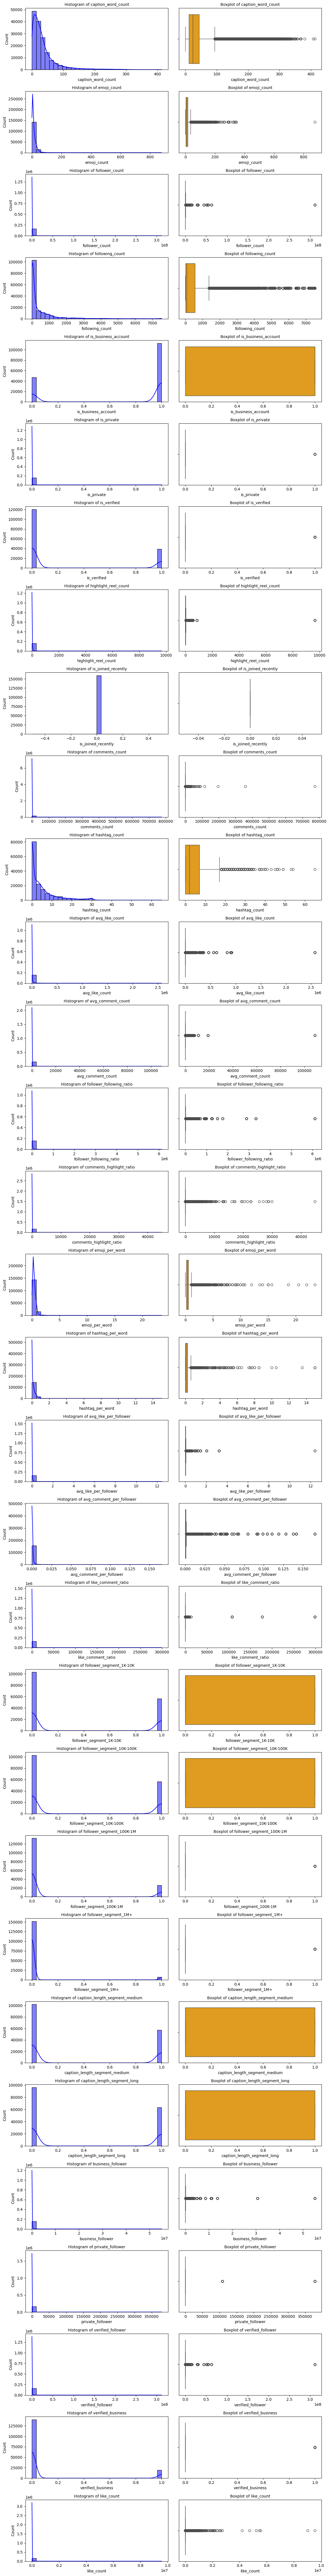

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine X_train_df and y_train_df for visualization
train_data = X_train_df.join(y_train_df)

# Plot histograms and boxplots for each feature to check for skewness
fig, axes = plt.subplots(len(train_data.columns), 2, figsize=(12, len(train_data.columns) * 3))

for i, column in enumerate(train_data.columns):
    # Histogram
    sns.histplot(train_data[column], ax=axes[i, 0], kde=True, bins=30, color="blue")
    axes[i, 0].set_title(f"Histogram of {column}", fontsize=10)

    # Boxplot
    sns.boxplot(x=train_data[column], ax=axes[i, 1], color="orange")
    axes[i, 1].set_title(f"Boxplot of {column}", fontsize=10)

plt.tight_layout()
plt.show()


In [30]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# function for log transformation
def apply_log_transform(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

# function for min-max normalization
def apply_minmax_normalization(df, columns, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# log transformation and min-max normalization
def preprocess_features(df, log_columns, normalize_columns, scaler=None):

    df = df.copy()

    for col in log_columns:
        if col in df.columns:
            df[col] = np.log1p(df[col])  # log1p(x) = log(x + 1)
    if scaler is None:
        scaler = MinMaxScaler()
    df[normalize_columns] = scaler.fit_transform(df[normalize_columns])

    return df, scaler

# feature lists
log_columns = [
    "caption_word_count",
    "emoji_count",
    "follower_count",
    "following_count",
    "highlight_reel_count",
    "comments_count",
    "hashtag_count",
    "avg_like_count",
    "avg_comment_count",
    "follower_following_ratio",
    "comments_highlight_ratio",
    "emoji_per_word",
    "hashtag_per_word",
    "avg_like_per_follower",
    "avg_comment_per_follower",
    "like_comment_ratio",
    "business_follower",
    "private_follower",
    "verified_follower",
    "verified_business",
]

normalize_columns = [
    "caption_word_count",
    "emoji_count",
    "follower_count",
    "following_count",
    "highlight_reel_count",
    "comments_count",
    "hashtag_count",
    "avg_like_count",
    "avg_comment_count",
    "follower_following_ratio",
    "comments_highlight_ratio",
    "emoji_per_word",
    "hashtag_per_word",
    "avg_like_per_follower",
    "avg_comment_per_follower",
    "like_comment_ratio",
    "business_follower",
    "private_follower",
    "verified_follower",
    "verified_business",
]

categorical_columns = [
    "is_business_account",
    "is_private",
    "is_verified",
    "is_joined_recently",
    "follower_segment_1K-10K",
    "follower_segment_10K-100K",
    "follower_segment_100K-1M",
    "follower_segment_1M+",
    "caption_length_segment_medium",
    "caption_length_segment_long",
    "user_scale_segment_micro",
    "user_scale_segment_mid",
]

# applying transformations
# -- train set --
X_train_df, train_scaler = preprocess_features(X_train_df, log_columns, normalize_columns)

# -- val set --
X_val_df, _ = preprocess_features(X_val_df, log_columns, normalize_columns, scaler=train_scaler)

# -- test set --
X_test_df, _ = preprocess_features(X_test_df, log_columns, normalize_columns, scaler=train_scaler)

# displaying results
print("Train Data (first 5 rows):")
display(X_train_df.head())

print("\nValidation Data (first 5 rows):")
display(X_val_df.head())

print("\nTest Data (first 5 rows):")
display(X_test_df.head())


Train Data (first 5 rows):


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,follower_following_ratio,comments_highlight_ratio,emoji_per_word,hashtag_per_word,avg_like_per_follower,avg_comment_per_follower,like_comment_ratio,follower_segment_1K-10K,follower_segment_10K-100K,follower_segment_100K-1M,follower_segment_1M+,caption_length_segment_medium,caption_length_segment_long,business_follower,private_follower,verified_follower,verified_business,user_scale_segment_micro,user_scale_segment_mid
0,0.237780,0.024467,0.592928,0.771471,1.0,0.0,0.0,0.003431,0.0,0.000000,0.043721,0.613768,0.046546,0.596912,0.000000,0.012226,0.002563,0.000818,0.000099,0.000354,0,1,0,0,0,1,0.797074,0.0,0.000000,0.0,0,1
1,0.010442,0.001644,0.752661,0.862140,0.0,0.0,1.0,0.006110,0.0,0.553277,0.000000,0.847713,0.608923,0.701293,0.171516,0.015267,0.000000,0.004665,0.001170,0.001412,0,0,1,0,0,0,0.000000,0.0,0.862595,0.0,0,0
2,0.088079,0.043746,0.672844,0.000000,0.0,0.0,0.0,0.000299,0.0,0.196609,0.420576,0.619362,0.199578,0.876866,0.102764,0.060121,0.076314,0.000201,0.000155,0.000226,0,1,0,0,1,0,0.000000,0.0,0.000000,0.0,0,0
3,0.041321,0.013101,0.680043,0.570958,1.0,0.0,0.0,0.001642,0.0,0.000000,0.065095,0.581082,0.120398,0.788012,0.000000,0.037293,0.022026,0.000099,0.000062,0.000175,0,1,0,0,1,0,0.846921,0.0,0.000000,0.0,0,0
4,0.126986,0.011470,0.467131,0.743579,1.0,0.0,0.0,0.000896,0.0,0.000000,0.000000,0.562547,0.207844,0.474596,0.000000,0.010977,0.000000,0.002845,0.005323,0.000097,1,0,0,0,0,1,0.725093,0.0,0.000000,0.0,1,0



Validation Data (first 5 rows):


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,follower_following_ratio,comments_highlight_ratio,emoji_per_word,hashtag_per_word,avg_like_per_follower,avg_comment_per_follower,like_comment_ratio,follower_segment_1K-10K,follower_segment_10K-100K,follower_segment_100K-1M,follower_segment_1M+,caption_length_segment_medium,caption_length_segment_long,business_follower,private_follower,verified_follower,verified_business,user_scale_segment_micro,user_scale_segment_mid
0,0.094637,0.059379,0.467304,0.721131,1.0,0.0,0.0,0.000597,0.0,0.000000,0.175087,0.516010,0.239564,0.498455,0.000000,0.037968,0.030454,0.010568,0.001397,0.000051,1,0,0,0,1,0,0.725192,0.0,0.000000,0.0,1,0
1,0.225881,0.121991,0.816014,0.520506,1.0,0.0,1.0,0.005515,0.0,0.000000,0.068172,0.681301,0.327388,0.904212,0.000000,0.032737,0.004722,0.000142,0.000004,0.000337,0,0,0,1,0,1,0.924723,0.0,0.897790,1.0,0,0
2,0.102250,0.035920,0.487920,0.447298,1.0,0.0,0.0,0.000000,0.0,0.461310,0.000000,0.624396,0.479867,0.679392,0.461310,0.021216,0.000000,0.033053,0.008294,0.000042,1,0,0,0,1,0,0.736989,0.0,0.000000,0.0,1,0
3,0.165390,0.065184,0.453887,0.506380,1.0,0.0,0.0,0.000597,0.0,0.279571,0.154328,0.579716,0.284927,0.629342,0.109385,0.023847,0.015221,0.028261,0.002450,0.000089,1,0,0,0,0,1,0.717515,0.0,0.000000,0.0,1,0
4,0.218895,0.121991,0.668203,0.792836,1.0,0.0,1.0,0.005515,0.0,0.387207,0.000000,0.695798,0.570174,0.663106,0.043957,0.033834,0.000000,0.005071,0.001019,0.000055,0,1,0,0,0,1,0.840146,0.0,0.815676,1.0,0,1



Test Data (first 5 rows):


,caption_word_count,emoji_count,follower_count,following_count,is_business_account,is_private,is_verified,highlight_reel_count,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,follower_following_ratio,comments_highlight_ratio,emoji_per_word,hashtag_per_word,avg_like_per_follower,avg_comment_per_follower,like_comment_ratio,follower_segment_1K-10K,follower_segment_10K-100K,follower_segment_100K-1M,follower_segment_1M+,caption_length_segment_medium,caption_length_segment_long,business_follower,private_follower,verified_follower,verified_business,user_scale_segment_micro,user_scale_segment_mid
0,0.081240,0.024495,0.609108,0.900519,1.0,0.0,1.0,0.000000,0.0,0.506621,0.000000,0.772049,0.565010,0.483338,0.514008,0.047306,0.000000,0.006200,0.011048,0.000619,0,1,0,0,1,0,0.813478,0.0,0.789785,1.0,0,1
1,0.060301,0.009848,0.645028,0.710834,1.0,0.0,1.0,0.000597,0.0,0.573749,0.043069,0.684491,0.449818,0.706103,0.396432,0.025423,0.027221,0.000606,0.001862,0.000329,0,1,0,0,1,0,0.833375,0.0,0.809103,1.0,0,1
2,0.064513,0.019629,0.770226,0.000000,1.0,0.0,1.0,0.000149,0.0,0.587989,0.000000,0.851709,0.600491,0.941076,0.524633,0.047306,0.000000,0.001595,0.000635,0.002811,0,0,1,0,1,0,0.902724,0.0,0.876432,1.0,0,0
3,0.004392,0.009848,0.742891,0.905440,0.0,0.0,0.0,0.004920,0.0,0.776650,0.000000,0.908747,0.743715,0.659848,0.478029,0.180572,0.000000,0.015045,0.008579,0.002019,0,0,1,0,0,0,0.000000,0.0,0.000000,0.0,0,0
4,0.204690,0.029344,0.536302,0.532964,1.0,0.0,0.0,0.000896,0.0,0.000000,0.084889,0.638781,0.171375,0.698304,0.000000,0.022455,0.016075,0.001888,0.001204,0.000754,1,0,0,0,0,1,0.773150,0.0,0.000000,0.0,0,1


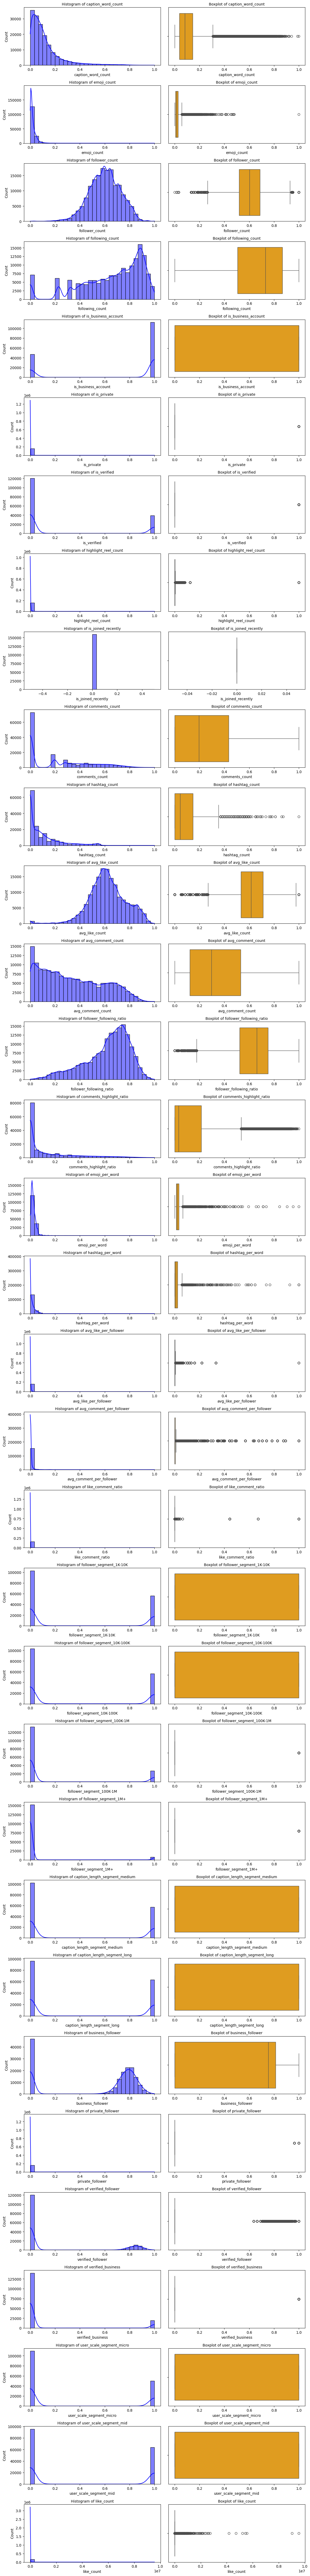

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine X_train_df and y_train_df for visualization
train_data = X_train_df.join(y_train_df)

# Plot histograms and boxplots for each feature to check for skewness
fig, axes = plt.subplots(len(train_data.columns), 2, figsize=(12, len(train_data.columns) * 3))

for i, column in enumerate(train_data.columns):
    # Histogram
    sns.histplot(train_data[column], ax=axes[i, 0], kde=True, bins=30, color="blue")
    axes[i, 0].set_title(f"Histogram of {column}", fontsize=10)

    # Boxplot
    sns.boxplot(x=train_data[column], ax=axes[i, 1], color="orange")
    axes[i, 1].set_title(f"Boxplot of {column}", fontsize=10)

plt.tight_layout()
plt.show()


In [25]:
def log_mse_like_counts(y_true, y_pred):
    """
    Calculate the Log Mean Squared Error (Log MSE) for like counts (log(like_count + 1)).
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Log transformation: log(like_count + 1)
    log_y_true = np.log1p(y_true)
    log_y_pred = np.log1p(y_pred)

    # Compute squared errors
    squared_errors = (log_y_true - log_y_pred) ** 2

    # Return the mean of squared errors
    return np.mean(squared_errors)


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np

# backward elimination function
def backward_elimination(X, y, significance_level=0.01):
    """
    Perform backward elimination on features based on p-values.

    Parameters:
    - X: DataFrame, feature matrix
    - y: array-like, target variable
    - significance_level: float, p-value threshold for feature elimination

    Returns:
    - selected_features: list, final set of selected feature names
    """
    features = X.columns.tolist()
    while True:
        # build the model
        X_with_const = sm.add_constant(X)  # add a constant term
        model = sm.OLS(y, X_with_const).fit()  # OLS regression

        # find the feature with the highest p-value
        p_values = model.pvalues.iloc[1:]  #exclude the constant term
        max_p_value = p_values.max()
        max_p_feature = p_values.idxmax()

        # stop if the highest p-value is below the significance threshold
        if max_p_value <= significance_level:
            break

        #otherwise remove
        print(f"Removing feature '{max_p_feature}' with p-value {max_p_value:.4f}")
        features.remove(max_p_feature)
        X = X.drop(columns=[max_p_feature])

    return features

#backward elimination
X_train_selected_features = backward_elimination(X_train_df, y_train_df.values.ravel())

#datasets from backward elimination
X_train_selected = X_train_df[X_train_selected_features]
X_val_selected = X_val_df[X_train_selected_features]
X_test_selected = X_test_df[X_train_selected_features]

print(f"Selected Features: {X_train_selected_features}")


Removing feature 'hashtag_per_word' with p-value 0.9919
Removing feature 'emoji_count' with p-value 0.6443
Removing feature 'emoji_per_word' with p-value 0.1048
Removing feature 'highlight_reel_count' with p-value 0.0427
Removing feature 'caption_length_segment_medium' with p-value 0.0387
Selected Features: ['caption_word_count', 'follower_count', 'following_count', 'is_business_account', 'is_private', 'is_verified', 'is_joined_recently', 'comments_count', 'hashtag_count', 'avg_like_count', 'avg_comment_count', 'follower_following_ratio', 'comments_highlight_ratio', 'avg_like_per_follower', 'avg_comment_per_follower', 'like_comment_ratio', 'follower_segment_1K-10K', 'follower_segment_10K-100K', 'follower_segment_100K-1M', 'follower_segment_1M+', 'caption_length_segment_long', 'business_follower', 'private_follower', 'verified_follower', 'verified_business', 'user_scale_segment_micro', 'user_scale_segment_mid']


In [27]:
X_train_selected

,caption_word_count,follower_count,following_count,is_business_account,is_private,is_verified,is_joined_recently,comments_count,hashtag_count,avg_like_count,avg_comment_count,follower_following_ratio,comments_highlight_ratio,avg_like_per_follower,avg_comment_per_follower,like_comment_ratio,follower_segment_1K-10K,follower_segment_10K-100K,follower_segment_100K-1M,follower_segment_1M+,caption_length_segment_long,business_follower,private_follower,verified_follower,verified_business,user_scale_segment_micro,user_scale_segment_mid
0,0.179177,9.376109,4.875197,1.0,0.0,0.0,0.0,0.000000,0.030769,4.433195,0.125163,4.511866,0.000000,0.000567,0.000068,0.000245,0,1,0,0,1,9.376109,0.0,0.000000,0.0,0,1
1,0.007264,12.568766,6.234411,0.0,0.0,1.0,0.0,3.401197,0.000000,9.356901,3.677451,6.336124,0.525010,0.003239,0.000811,0.000979,0,0,1,0,0,0.000000,0.0,12.568766,0.0,0,0
2,0.062954,10.866528,0.000000,0.0,0.0,0.0,0.0,0.693147,0.338462,4.517657,0.658056,10.866528,0.287682,0.000139,0.000107,0.000157,0,1,0,0,0,0.000000,0.0,0.000000,0.0,0,0
3,0.029056,11.010861,2.708050,1.0,0.0,0.0,0.0,0.000000,0.046154,3.964886,0.356675,8.303042,0.000000,0.000069,0.000043,0.000121,0,1,0,0,0,11.010861,0.0,0.000000,0.0,0,0
4,0.092010,7.400010,4.510860,1.0,0.0,0.0,0.0,0.000000,0.000000,3.717498,0.693147,2.942702,0.000000,0.001974,0.003697,0.000067,1,0,0,0,1,7.400010,0.0,0.000000,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159201,0.072639,8.409831,2.079442,1.0,0.0,0.0,0.0,0.000000,0.076923,3.267973,0.203599,6.331947,0.000000,0.000452,0.000304,0.000069,1,0,0,0,0,8.409831,0.0,0.000000,0.0,1,0
159202,0.125908,9.284334,7.593374,0.0,0.0,0.0,0.0,0.000000,0.184615,3.622288,0.268264,1.860069,0.000000,0.000272,0.000173,0.000093,0,1,0,0,1,0.000000,0.0,0.000000,0.0,0,1
159203,0.014528,6.993015,5.902633,1.0,0.0,0.0,0.0,0.000000,0.076923,3.056357,0.194156,1.379440,0.000000,0.001495,0.001190,0.000056,1,0,0,0,0,6.993015,0.0,0.000000,0.0,1,0
159204,0.259080,11.556914,1.791759,1.0,0.0,0.0,0.0,2.639057,0.230769,6.700135,3.876867,9.765202,0.624154,0.000624,0.002736,0.000056,0,0,1,0,1,11.556914,0.0,0.000000,0.0,0,0


## 4. Model Training

In [72]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
import json
import math

# define the random forest regressor model
rf = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42, min_samples_split= 2)

# train the mdoel
rf.fit(X_train_selected, y_train.ravel())

# predict the test instances (in log form)
y_val_pred_log = rf.predict(X_val_selected)

# scale the test results into original form(we had predicted them in log form)
y_val_pred = np.expm1(y_val_pred_log)


# r2 and log mse
r2 = r2_score(y_val_df["like_count"], y_val_pred)
log_mse_val = log_mse_like_counts(y_val_df["like_count"], y_val_pred)


print(f"Validation Log MSE: {log_mse_val:.4f}")
print(f"Validation R2 Score: {r2:.4f}")


Validation Log MSE: 0.5548
Validation R2 Score: 0.7314


In [68]:
# selecting the best rounding method (our results is float)
def evaluate_rounding(y_true, y_pred):

    y_true = y_true["like_count"].values
    log_mses = {}

    # 0 for neg values
    def sanitize_and_round(values, func):
        return [max(0, func(val)) for val in values]

    rounded_y_pred_round = sanitize_and_round(y_pred, round)
    log_mses["round"] = log_mse_like_counts(y_true, rounded_y_pred_round)

    rounded_y_pred_floor = sanitize_and_round(y_pred, math.floor)
    log_mses["floor"] = log_mse_like_counts(y_true, rounded_y_pred_floor)

    rounded_y_pred_ceil = sanitize_and_round(y_pred, math.ceil)
    log_mses["ceil"] = log_mse_like_counts(y_true, rounded_y_pred_ceil)

    rounded_y_pred_int = sanitize_and_round(y_pred, int)
    log_mses["int"] = log_mse_like_counts(y_true, rounded_y_pred_int)

    best_method = min(log_mses, key=log_mses.get)
    return best_method, log_mses

best_method, log_mses = evaluate_rounding(y_val_df, y_val_pred)
print(f"Best rounding method: {best_method}")
for method, mse_value in log_mses.items():
     print(f"{method} Log MSE: {mse_value:.4f}")


Best rounding method: round
round Log MSE: 0.5854
floor Log MSE: 0.5890
ceil Log MSE: 0.5868
int Log MSE: 0.5890


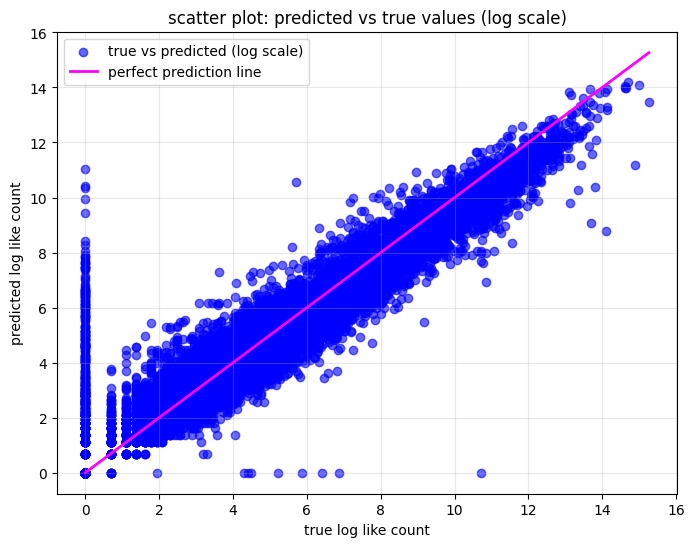

In [69]:
import matplotlib.pyplot as plt

# create predicted values rounded and set negative predictions to zero
y_val_pred = [max(0, val) for val in y_val_pred]  # set negatives to zero
if best_method == "round":
    y_val_pred_rounded = [round(val) for val in y_val_pred]
elif best_method == "floor":
    y_val_pred_rounded = [math.floor(val) for val in y_val_pred]
elif best_method == "ceil":
    y_val_pred_rounded = [math.ceil(val) for val in y_val_pred]
elif best_method == "int":
    y_val_pred_rounded = [int(val) for val in y_val_pred]

# transform true values and predictions to log1p scale
log_true = np.log1p(y_val_df["like_count"])
log_pred = np.log1p(y_val_pred_rounded)

# scatter plot and prediction curve (log scale)
plt.figure(figsize=(8, 6))
plt.scatter(
    log_true,
    log_pred,
    color="blue", alpha=0.6, label="true vs predicted (log scale)"
)
plt.plot(
    [np.min(log_true), np.max(log_true)],
    [np.min(log_true), np.max(log_true)],
    color="magenta",
    linewidth=2,
    label="perfect prediction line"
)
plt.xlabel("true log like count")
plt.ylabel("predicted log like count")
plt.title("scatter plot: predicted vs true values (log scale)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 5.Save the Output

In [71]:
# make predictions on the test set
y_test_pred = rf.predict(X_test_selected)  # predict on the selected features
y_test_pred = np.expm1(y_test_pred)  # reverse the log transformation

y_test_pred = [max(0, val) for val in y_test_pred]  # set negative predictions to zero

# convert predictions to integers using the best rounding method
if best_method == "round":
    y_test_pred_rounded = [round(val) for val in y_test_pred]
elif best_method == "floor":
    y_test_pred_rounded = [math.floor(val) for val in y_test_pred]
elif best_method == "ceil":
    y_test_pred_rounded = [math.ceil(val) for val in y_test_pred]
elif best_method == "int":
    y_test_pred_rounded = [int(val) for val in y_test_pred]

# save test set predictions in JSON format (rounded values)
test_predictions = {
    int(id): like_count_pred
    for id, like_count_pred in zip(test_ids, y_test_pred_rounded)
}

output_file = "prediction-regression-round3.json"
with open(output_file, "w") as f:
    json.dump(test_predictions, f, indent=4)

print(f"Predictions successfully saved to {output_file}.")


Predictions successfully saved to prediction-regression-round3.json.
